# Vision Transformer for Traction Force Microscopy (ViT-TFM)

In [1]:
import copy
import datetime
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import sys

from cv2 import resize
from datetime import datetime
from gc import collect
from os import cpu_count
from sklearn.model_selection import train_test_split
from time import sleep
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm

sys.path.append(f"{os.getcwd()}/ViT-TFM/")
import VisionTransformer as vit

2022-11-15 15:10:01.048539: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 15:10:01.136338: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-15 15:10:01.136354: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-15 15:10:01.160748: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-15 15:10:01.526738: W tensorflow/stream_executor/platform/de

In [2]:
random_seed = 1
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
cudnn.benchmark = True

In [3]:
collect()
torch.cuda.empty_cache()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cuda


## 1. Taxonomy of an inverse problem
Ongie, G., Jalal, A., Metzler, C. A., Baraniuk, R. G., Dimakis, A. G. & Willett, R. (2020). Deep Learning Techniques for Inverse Problems in Imaging. IEEE Journal on Selected Areas in Information Theory, 1(1), 39–56. https://doi.org/10.1109/jsait.2020.2991563

<h4><center>$y = A(x) + \epsilon$</center></h4>

- $y$: measurement (e.g. displacements)
- $x$: signal (e.g. traction forces)
- $A$: (non-linear) foward operator
- $\epsilon$: noise

__Goal__: recover $x$ from $y$

__Problem__: A is ill-posed, (matrix-) inversion is not possible


__Approach__: 
  1. Supervised approach: create a matched dataset by simulating the forward operator on clean data.
  2. Train model to reconstruct signal by taking (corrupted) measurements as input.
  3. Generalize to unseen measurements.

## 2. Comparison: CNN from [Kratz et al.](https://www.biorxiv.org/content/biorxiv/early/2022/09/03/2022.09.02.506331.full.pdf) and ViT

This section serves as a 'sanity check' for my ViT architecture modified for TFM. I trained the model on a set of 25.000 clean pairs of (displacement fields, traction fields) for 10 epochs without any hyperparameter tuning.

Load weights of benchmark CNN and my ViT.

In [4]:
vit_weights = vit.VisionTransformer(dspl_size=104, patch_size=8, embed_dim=128, depth=12, n_heads=8, mlp_ratio=4.,p=0., attn_p=0.,drop_path=0).double()

In [5]:
if torch.cuda.is_available():
    vit_weights.load_state_dict(torch.load('ViT-TFM/logs_and_weights/ViT-2022-Nov-14 18:27:57/ViT-2022-Nov-14 18:27:57_best_val_loss_2.2e-05.pth')['best_model_weights'], strict=False)
else:
    vit_weights.load_state_dict(torch.load('ViT-TFM/logs_and_weights/ViT-2022-Nov-14 18:27:57/ViT-2022-Nov-14 18:27:57_best_val_loss_2.2e-05.pth', map_location=torch.device('cpu'))['best_model_weights'], strict=False)        

In [6]:
cnn_weights = keras.models.load_model('mltfm/models/model_noise_1e-4.h5')

2022-11-15 15:10:03.518203: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-15 15:10:03.518494: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alexrichard/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-11-15 15:10:03.518528: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/alexrichard/.local/lib/python3.8/site-packages/cv2/../../lib64:
2022-11-15 15:10:03.518558: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: l

Load a test set of 25 clean samples. Neither the CNN nor the ViT have seen these during training.

In [7]:
dspl = h5py.File('ViT-TFM/data/displacements_25.h5')["data"]
trac = h5py.File('ViT-TFM/data/tractions_25.h5')["data"]

dspl_ = np.moveaxis(np.array(dspl),3 ,1)
trac_ = np.moveaxis(np.array(trac),3 ,1)

X_test = torch.from_numpy(dspl_).double()
Y_test = torch.from_numpy(trac_).double()

Compute the predictions and losses for each sample.

In [8]:
pred_vit, _ = vit_weights(X_test)
pred_cnn = cnn_weights.predict(dspl)

1/1 [==============================] - 0s 226ms/step


In [9]:
loss = torch.nn.MSELoss(reduction='none')
loss_vit = torch.sum(loss(pred_vit, Y_test), (1, 2, 3))
loss_cnn = torch.sum(loss(torch.tensor(np.moveaxis(pred_cnn, 3, 1)), Y_test), (1, 2, 3))

loss_vit = torch.reshape(loss_vit, (25, 1))
loss_cnn = torch.reshape(loss_cnn, (25, 1))

In [10]:
pd.DataFrame(np.array(torch.cat((loss_vit, loss_cnn), 1).detach().numpy()), columns=['loss_ViT', 'loss_CNN'])

,loss_ViT,loss_CNN
0,2.756583,0.953331
1,5.602578,2.071338
2,2.443280,0.819685
3,2.760871,1.019594
4,3.319478,1.171545
5,4.787753,1.809745
6,3.088468,1.016019
7,5.567116,2.160380
8,4.106822,1.641007
9,6.892022,2.361687


The per sample loss of the ViT is approximately 3x larger than the CNN loss. This could be rooted in the significantly recuced training time of the vanilla ViT (10 epochs) compared to the training time of the tuned CNN (100 epochs).

Visualize the first test sample `test_sample_00`.

<IPython.core.display.Javascript object>


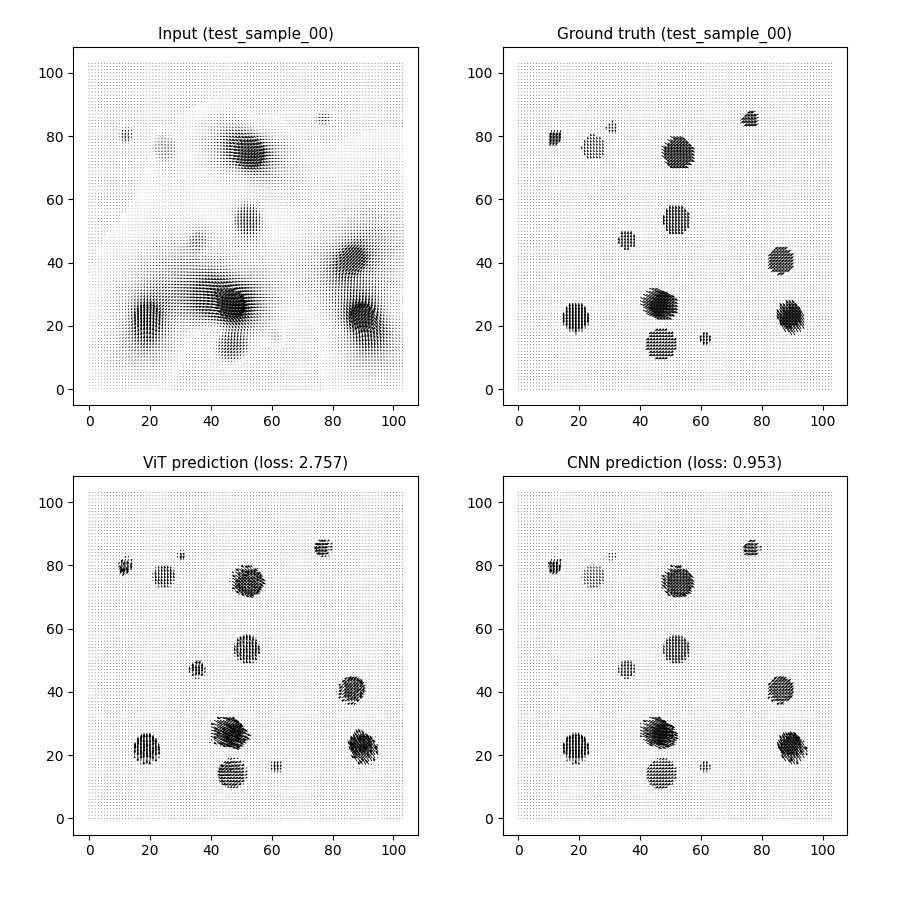

Text(0.5, 1.0, 'CNN prediction (loss: 0.953)')

In [11]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(2,2, figsize=(9, 9))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0, 0].quiver(dspl[0,:,:,0], dspl[0,:,:,1], scale=1)
axs[0, 0].set_title('Input (test_sample_00)', {'fontsize': 11})

axs[0, 1].quiver(trac[0,:,:,0], trac[0,:,:,1], scale=10)
axs[0, 1].set_title('Ground truth (test_sample_00)', {'fontsize': 11})

axs[1, 0].quiver(pred_vit[0,0,:,:].detach().numpy(), pred_vit[0,1,:,:].detach().numpy(), scale=10)
axs[1, 0].set_title(f'ViT prediction (loss: {torch.round(loss_vit[0,0], decimals=3)})', {'fontsize': 11})

axs[1, 1].quiver(pred_cnn[0,:,:,0], pred_cnn[0,:,:,1], scale=10)
axs[1, 1].set_title(f'CNN prediction (loss: {torch.round(loss_cnn[0,0], decimals=3)})', {'fontsize': 11})

## 3. Optimization possibilities

- Transfer learning
- Complexity of decoder (linear layer, FFNN, Convolutions, 'proper' decoder)
- Pretraining on low-resolution samples and finetuning on high resolution
- Multitask learning: Linear combination of different objectives such as
        - MSE
        - Classification: Split dataset in three groups, corrupt each group with Gaussian noise of different magnitude, infer label
        - Deviation of Traction Magnitude at Adhesions (DTMA)
        - Deviation of Traction Magnitude in the Background (DTMB)
        - Signal to Noise Ratio (SNR)
        - Deviation of Traction Direction at Adhesions (DDA)
- Hyperparameter tuning: 
        - Depth of encoder/decoder
        - patch size
        - embedding dimension
        - number of attention heads
        - mlp ratio (number of hidden layers in MLP module)
        - dropout, attention dropout and stochastic path prob
        - weight initialization
        - optimizer
        - learning rate schedule
        - ... 

## 4. Visualization of attention maps

In this part I visualize the attention maps for two test samples based on the attention rollout principle introduced by [Abnar and Zuidema](https://arxiv.org/pdf/2005.00928.pdf).

In [12]:
def compute_attention_map(attn_scores):
    """
    Compute the attention rollout tensors for each layer in a ViT architecture. We assume a batch size of 1.
    
    Parameters
    __________
    attn_scores : List
        List of raw attention tensors for each encoder block.
        
    Returns
    _______
    joint_attentions : List
        List of attention rollouts for each layer.
    
    grid_size : int
        Number of patches per dimension of original (quadratic) input.
    """
    # Stack raw attention tensors in a matrix, get rid of singleton (batch) dimension and average over all attention heads per layer.
    attn_mat = torch.stack(attn_scores) # (depth, n_samples, n_heads, n_patches, n_patches)
    attn_mat = attn_mat.squeeze(1) # (depth, n_heads, n_patches, n_patches)
    attn_mat = torch.mean(attn_mat, dim=1) # (depth, n_heads, n_patches, n_patches)
    
    # Account for skip connections in the architecture
    residual_attn = torch.eye(attn_mat.size(1))
    aug_attn_mat = attn_mat + residual_attn
    aug_attn_mat = aug_attn_mat / aug_attn_mat.sum(dim=-1).unsqueeze(-1)
    
    # Recursively compute attention rollouts 
    joint_attentions = torch.zeros(aug_attn_mat.size())
    joint_attentions[0] = aug_attn_mat[0].double()
    for n in range(1, aug_attn_mat.size(0)):
        joint_attentions[n] = aug_attn_mat[n].double() @ joint_attentions[n-1].double()
    
    grid_size = int(np.sqrt(aug_attn_mat.size(-1)))
    
    return joint_attentions, grid_size

We extract the attention weights of each encoder block for the first test sample and compute the attention rollouts.

In [13]:
_, attn_scores = vit_weights((X_test[0, :, :, :][np.newaxis, ...]))
joint_attentions, grid_size = compute_attention_map(attn_scores)

Visualize the test sample and select one patch. We will then track the attention rollout of this patch among the network.

<IPython.core.display.Javascript object>


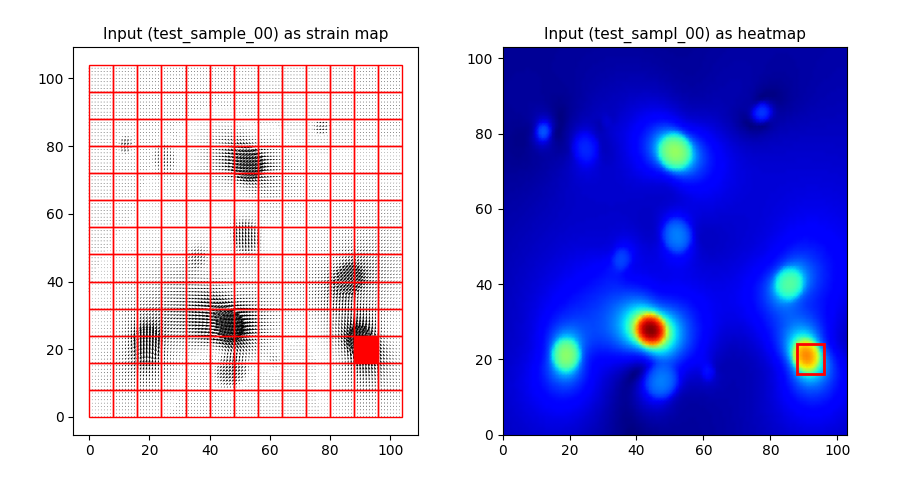

In [14]:
from matplotlib.patches import Rectangle

fig, axs = plt.subplots(1,2, figsize=(9, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(X_test[0,0,:,:], X_test[0,1,:,:], scale=1)
axs[0].set_title('Input (test_sample_00) as strain map', {'fontsize': 11})

C = np.sqrt(X_test[0,0,:,:] **2 + X_test[0,1,:,:] ** 2)
im = axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].set_title('Input (test_sampl_00) as heatmap', {'fontsize': 11})


for row in range(0, 13):
    for column in range(0, 13):
        if row == 2 and column == 11:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=True))
        else:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=False))
    
    
axs[1].add_patch(Rectangle(xy=(11*8, 2*8), width=8, height=8, linewidth=2, color='red', fill=False))

Plot rolled out attention map of chosen patch at each layer of the encoder.

<IPython.core.display.Javascript object>


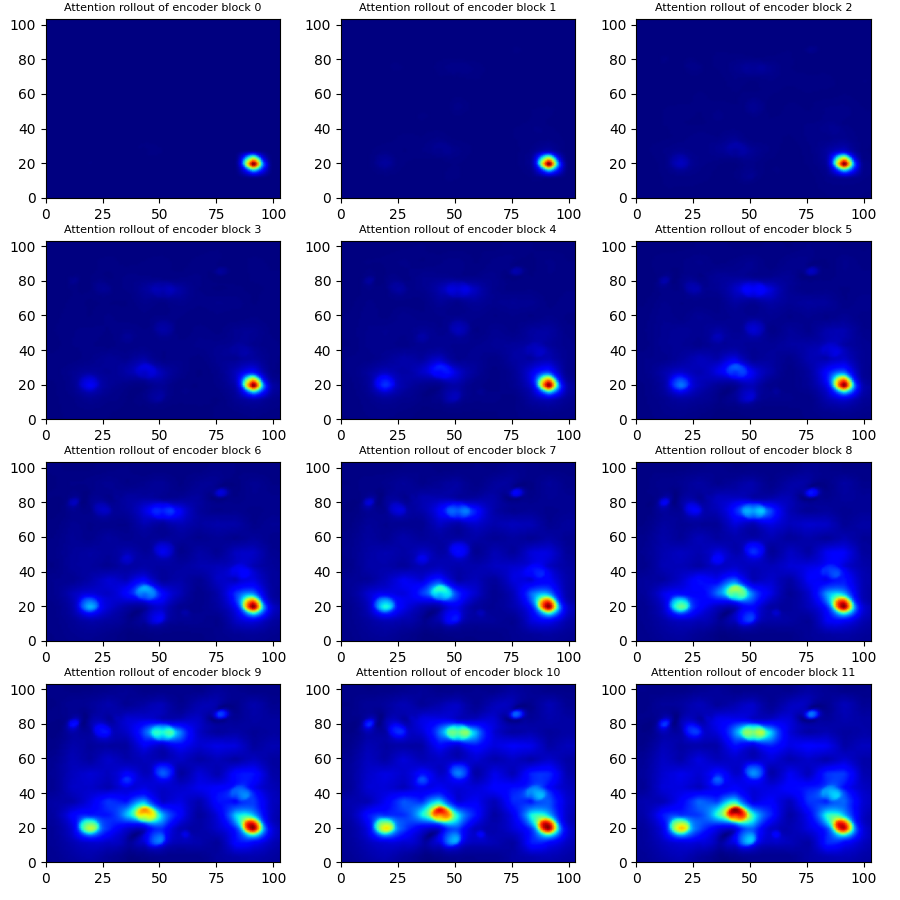

In [15]:
fig, axs = plt.subplots(4, 3, figsize=(9, 9))
fig.tight_layout(pad=1, w_pad=1, h_pad=1)
ind = 0
for i in range(0, 4):
    for j in range(0, 3):
        mask = joint_attentions[ind][37, 0:].reshape(grid_size, grid_size).detach().numpy()
        mask = resize(mask / mask.max(), (104, 104))
        mask = mask[np.newaxis, ...]
        result = torch.tensor(mask) * X_test[0,:,:,:]

        C = np.sqrt(result[0,:,:] **2 + result[1,:,:] ** 2)
        im = axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].set_title(f'Attention rollout of encoder block {ind}', {'fontsize': 8})
        ind += 1

Next, another test sample with a more "cell-like" geometry is analysed.

In [16]:
sys.path.append(f"{os.getcwd()}/DL_TFM/scripts/")
from data_preparation import matFiles_to_npArray

In [17]:
X_test_ = matFiles_to_npArray('comparables/generic')[1]
Y_test_ = matFiles_to_npArray('comparables/generic')[0]
X_test_ = np.moveaxis(np.array(X_test_['dspl'])[np.newaxis, ...], 3, 1)
Y_test_ = np.moveaxis(np.array(Y_test_['trac'])[np.newaxis, ...], 3, 1)

In [18]:
_, attn_scores = vit_weights(torch.tensor(X_test_).double())

In [19]:
joint_attentions, grid_size = compute_attention_map(attn_scores)

<IPython.core.display.Javascript object>


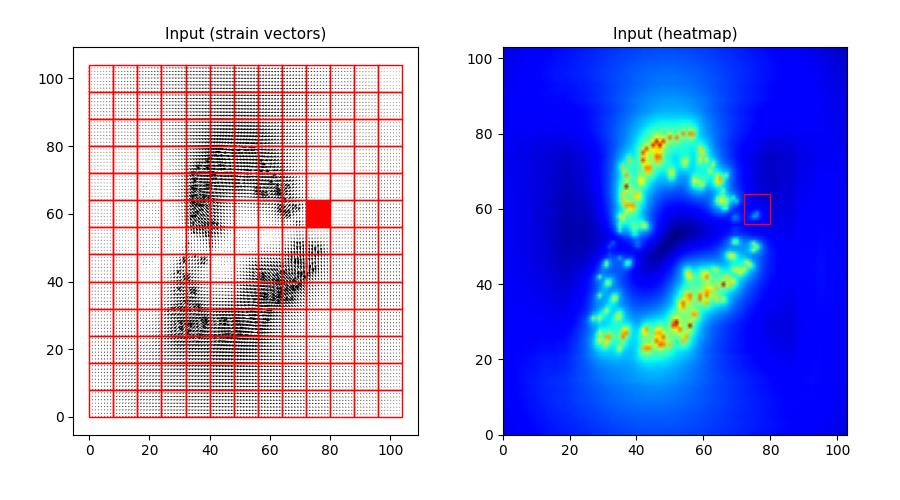

In [20]:
from matplotlib.patches import Rectangle

fig, axs = plt.subplots(1,2, figsize=(9, 5))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)

axs[0].quiver(X_test_[0,0,:,:], X_test_[0,1,:,:], scale=20)
axs[0].set_title('Input (strain vectors)', {'fontsize': 11})

C = np.sqrt(X_test_[0,0,:,:] **2 + X_test_[0,1,:,:] ** 2)
im = axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].set_title('Input (heatmap)', {'fontsize': 11})


for row in range(0, 13):
    for column in range(0, 13):
        if row == 7 and column == 9:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=True))
        else:
            axs[0].add_patch(Rectangle(xy=(column*8, row*8), width=8, height=8, linewidth=1, color='red', fill=False))
    
    
axs[1].add_patch(Rectangle(xy=(9*8, 7*8), width=8, height=8, linewidth=1, color='red', fill=False))

<IPython.core.display.Javascript object>


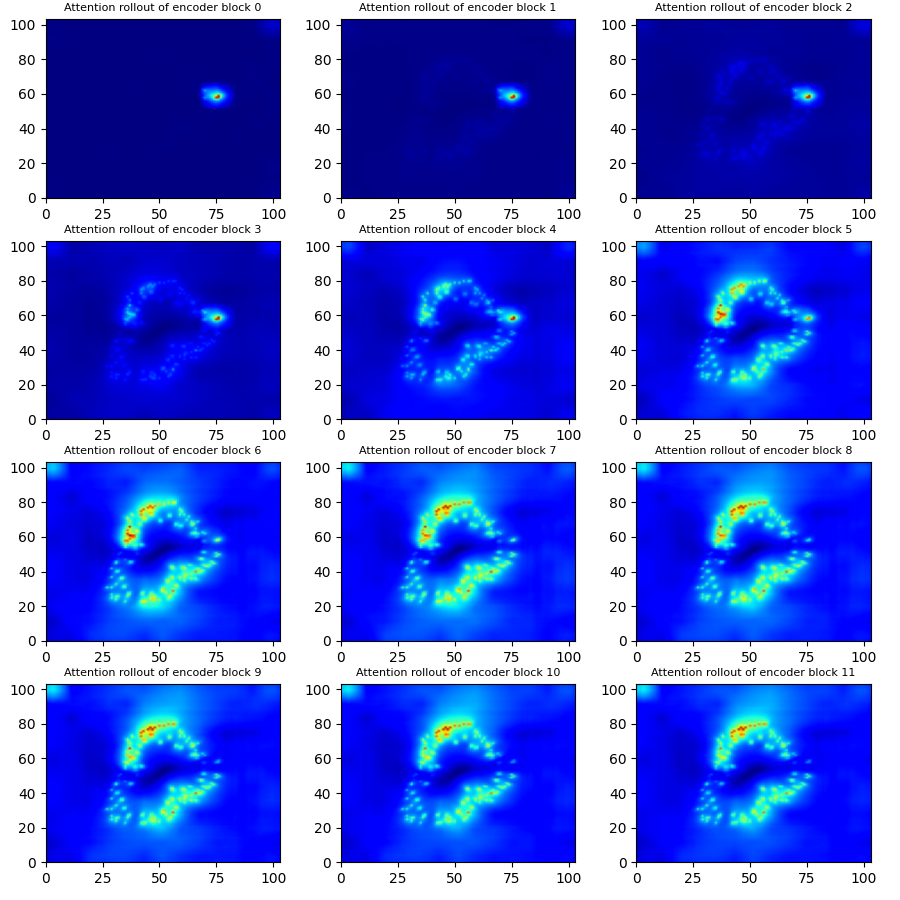

In [24]:
fig, axs = plt.subplots(4, 3, figsize=(9, 9))
fig.tight_layout(pad=1, w_pad=1, h_pad=1)
ind = 0
for i in range(0, 4):
    for j in range(0, 3):
        mask = joint_attentions[ind][100, 0:].reshape(grid_size, grid_size).detach().numpy()
        mask = resize(mask / mask.max(), (104, 104))
        mask = mask[np.newaxis, ...]
        result = torch.tensor(mask) * X_test_[0,:,:,:]

        C = np.sqrt(result[0,:,:] **2 + result[1,:,:] ** 2)
        im = axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].pcolormesh(C, cmap='jet', shading='gouraud')
        axs[i, j].set_title(f'Attention rollout of encoder block {ind}', {'fontsize': 8})
        ind += 1

Since the attention rollout method tends to often highlight irrelevant tokens, we do not draw conclusions from these plots at the moment. For later experiments, more advanced approaches to visualize the attention flow in a Transformer model should be considered (e.g. by [Chefer et al.](https://arxiv.org/pdf/2012.09838.pdf)).

## 5. Predictive uncertainty

#### 5.1 MC dropout

For both the CNN and Vit, compute 100 forward passes on the same test sample with dropout enabled.

In [137]:
layers_indices = []
for index, layer in enumerate(cnn_weights.layers):
    print(layer)
layers_indices

[]

In [126]:
from main_dist import inference_with_dropout

test_sample_00 = X_test[0,:,:,:][np.newaxis, ...]
test_gt_00 = Y_test[0,:,:,:][np.newaxis, ...]

predictions_vit = []
predictions_cnn = []
for i in range(0, 100):
    predictions_vit.append(inference_with_dropout(vit_weights, test_sample_00, return_attn_scores=False))
    predictions_cnn.append(torch.tensor(np.moveaxis(np.array((cnn_weights(dspl[0][np.newaxis, ...], training=True))), 3, 1)))

Calculate loss per prediction and loss of averaged prediction.

In [128]:
stacked_predictions_vit = torch.stack(predictions_vit, dim=0).squeeze(1)
stacked_predictions_cnn = torch.stack(predictions_cnn, dim=0).squeeze(1)

In [131]:
averaged_pred = 1/len(predictions) * stacked_predictions.sum(0)

losses = []
for i in range(0, 100):
    losses.append(torch.sum(loss(predictions[i], test_gt_00), (1, 2, 3)))
losses.append(torch.sum(loss(averaged_pred, test_gt_00), (1, 2, 3)))

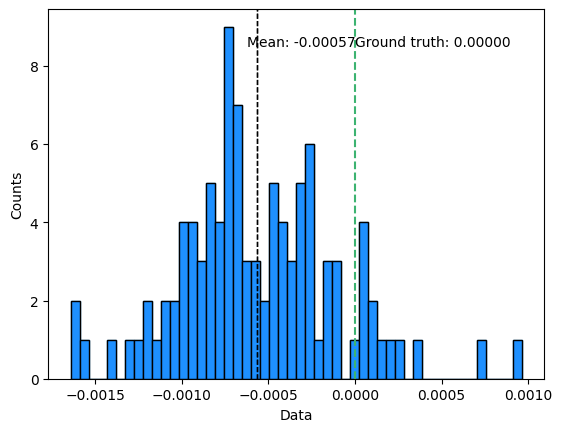

In [132]:
%matplotlib inline

mean = stacked_predictions[:,0,0,0].detach().numpy().mean()
var = stacked_predictions[:,0,0,0].detach().numpy().var()
gt = test_gt_00[0,0,0,0]

counts, bins = np.histogram(stacked_predictions[:,0,0,0].detach().numpy(), bins=50)
plt.stairs(counts, bins)
plt.hist(bins[:-1], bins, weights=counts, color='dodgerblue', ec='black')
plt.axvline(mean, color='k', linestyle='dashed', linewidth=1)
min_ylim, max_ylim = plt.ylim()
plt.text(mean*1.1, max_ylim*0.9, 'Mean: {:.5f}'.format(mean))
plt.axvline(mean, color='black', linestyle='dashed', linewidth=1)
plt.text(gt*1.1, max_ylim*0.9, 'Ground truth: {:.5f}'.format(gt))
plt.axvline(gt, color='mediumseagreen', linestyle='dashed', linewidth=1.5)
plt.ylabel('Counts')
plt.xlabel('Data');

Compute empirical variances for each predicted value.

In [133]:
variances_vit = np.var(stacked_predictions_vit.detach().numpy(), axis=0)
variances_cnn = np.var(stacked_predictions_cnn.detach().numpy(), axis=0)

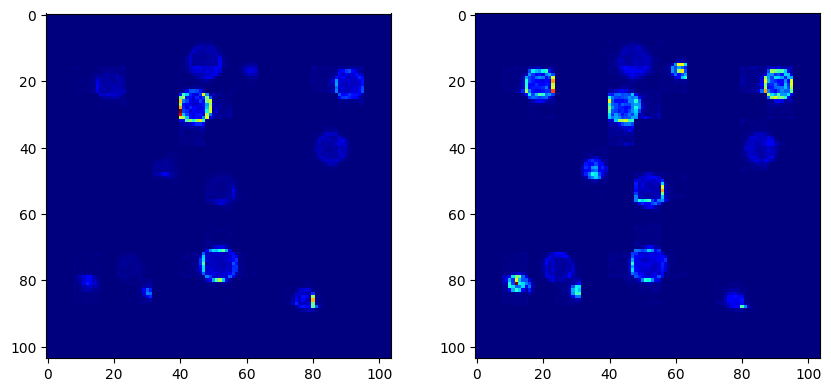

In [134]:
%matplotlib inline

fig, axs = plt.subplots(1,2, figsize=(9, 9))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0].imshow(variances_vit[0,:,:] , cmap='jet', interpolation = 'nearest' )
axs[1].imshow(variances_vit[1,:,:] , cmap='jet', interpolation = 'nearest' )

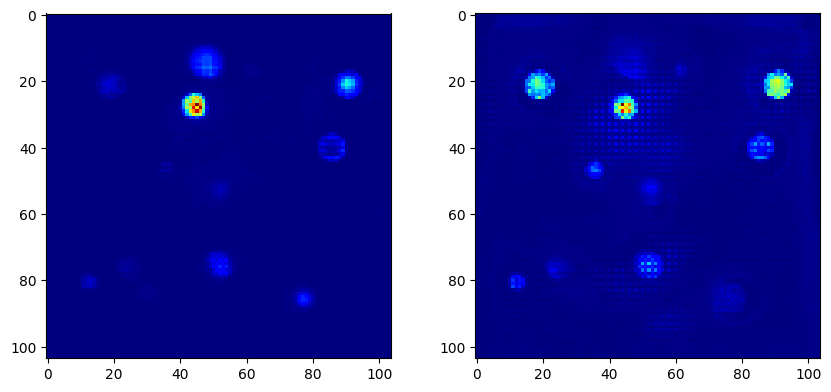

In [135]:
%matplotlib inline

fig, axs = plt.subplots(1,2, figsize=(9, 9))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0].imshow(variances_cnn[0,:,:] , cmap='jet', interpolation = 'nearest' )
axs[1].imshow(variances_cnn[1,:,:] , cmap='jet', interpolation = 'nearest' )

<IPython.core.display.Javascript object>


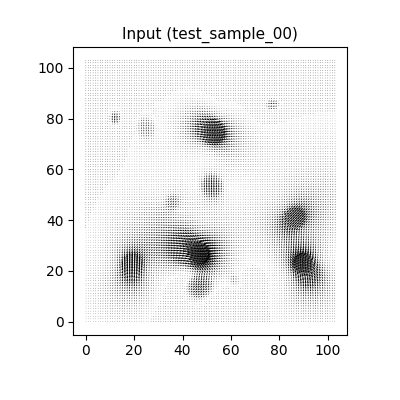

Text(0.5, 1.0, 'Input (test_sample_00)')

In [58]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(1,1, figsize=(4, 4))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs.quiver(dspl[0,:,:,0], dspl[0,:,:,1], scale=1)
axs.set_title('Input (test_sample_00)', {'fontsize': 11})